#CMU-MoCap-load-dataset.ipynb
This is a loader for the CMU grand challenge dataset with motion capture for subjects making several recipes.

The data used is obtained from kitchen.cs.cmu.edu and the data collection was funded in part by the National Science Foundation under Grant No. EEEC-0540865.

http://kitchen.cs.cmu.edu/main.php

If you use this dataset in your work please follow the dataset authors' citation request [here](https://www.ri.cmu.edu/publications/guide-to-the-carnegie-mellon-university-multimodal-activity-cmu-mmac-database/).

This is work in progress and frequently updated, please check the repository at our [IMICS Lab Github repository](https://github.com/imics-lab/load_data_time_series) for the latest.  Much appreciation to Vangelis Metsis and Alex Katrompas for the [initial loader](https://git.txstate.edu/imics-lab/tattend/tree/main/scripts) from which multiple methods have been derived.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* A lot.  This version is early work.


In [2]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
import time
#import csv # probably not needed once download processes zip
import pandas as pd
import numpy as np
import tensorflow as tf
from numpy import savetxt
#from tabulate import tabulate # for verbose tables, showing data
from tensorflow.keras.utils import to_categorical # for one-hot encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from time import gmtime, strftime, localtime #for displaying Linux UTC timestamps in hh:mm:ss
from datetime import datetime, date, timedelta
import urllib.request # to get files from web w/o !wget
import zipfile

In [3]:
def get_web_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from", url)
        urllib.request.urlretrieve(url, filename=fname)

# Load shared transform (xform) functions and utils

In [4]:
try:
    import load_data_transforms as xform
except:
    get_web_file(fname = 'load_data_transforms.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_transforms.py')
    import load_data_transforms as xform

try:
    import load_data_utils as utils  
except:
    get_web_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')
    import load_data_utils as utils

# Setup environment and dataset parameters

In [5]:
# environment and execution parameters
my_dir = '.' # replace with absolute path if desired
ir1_dir = 'cmu_ir1' # this is where the raw data IR1s will be stored
#working_dir = 'psg_temp'
# if not os.path.exists(working_dir):
#     os.mkdir(working_dir)
interactive = True # for exploring data and functions interactively
verbose = True

# dataset parameters
all_channel_list = [] # this will get populated from the IR1 dataframe column names
xform.time_steps = 500 # IR1 dataframes are set to 100Hz
xform.stride = 500 # how far to move for next window, if = times_steps no overlap
# The label_map_<dataset> contains a mapping from strings to ints for all
# possible labels in the entire dataset.   This allows for predictable conversion
# regardless of the slices.
label_map_psg = dict(
    Cardiac = {'Normal':0,'Bradycardia':1,'Tachycardia':2,'LongRR':3,'PttDrop':4,'HeartrateDrop':5,'HeartRateRise':6,'Asystole':7,'SinusTachycardia':8,'NarrowComplexTachycardia':9,'WideComplexTachycardia':10,'AtrialFibrilation':11},
    Limb = {'Normal':0,'LegMovement':1,'AlternatingLegMuscleActivation':2,'HypnagogicFootTremor':3,'ExcessiveFreagmentaryMyoclonus':4,'RythmicMovementDisorder':5},
    Nasal = {'Normal':0, 'Snore':1 },
    Neuro = {'Normal':0,'Arousal':1},
    Respiratory = {'Normal':0,'ObstructiveApnea':1,'CentralApnea':2,'MixedApnea':3,'Hypopnea':4,'CheyneStokesRespiration':5,'PeriodicRespiration':6,'Respiratoryeffort-relatedarousal(RERA)':7},
    SpO2 = {'Normal':0,'RelativeDesaturation':1,'AbsoluteDesaturation':2})

# setup a global readme so various methods can append info as needed
readme = 'This readme auto-generated by CMU-kitchen_load_dataset.ipynb\n'
readme += 'Executed on '
today = date.today()
readme += today.strftime("%B %d, %Y") + "\n"
readme += 'ref: https://github.com/imics-lab/load_data_time_series \n'

# CMU kitchen specific functions
Much appreciation to Vangelis Metsis and Alex Katrompas for the [initial loader](https://git.txstate.edu/imics-lab/tattend/tree/main/scripts) from which multiple methods have been derived.


In [6]:
df_labels = pd.DataFrame() # workaround to get a global
# Assign labels to each frame in the time synchronization data
def assign_label(frame_number, offset):
    for _, row in df_labels.iterrows():
        if row['start_frame'] <= frame_number - (offset - 1) <= row['end_frame']:
            return row['label']
    return 'unknown'

# Function to process the IMU data file
def process_data_file(file_path, archive):
    with archive.open(file_path) as f:
        # Get the sensor_ID from the first line of the file, e.g. "sensor_ID	2794"
        sensor_id = f.readline().decode('utf-8').split('\t')[1].strip()

        # Read the rest of the file into a Pandas DataFrame
        df = pd.read_csv(f, delim_whitespace=True)

    # Check if 'Count' column contains any string values
    if df['Count'].apply(lambda x: isinstance(x, str)).any():
        # Drop rows containing "ERROR_1--TIMEOUT" in the Count column
        df = df[~df['Count'].str.contains('ERROR')]

    # Convert SysTime to datetime object
    df['system_time'] = df['SysTime'].str.replace('_', ':')
    df['system_time'] = pd.to_datetime(df['system_time'], format='%H:%M:%S:%f')
    df.drop('SysTime', axis=1, inplace=True)

    # Remove sensor_ID row and reset the index
    # this next line is commented out, it shouldn't be here,
    # tested by vangelis, TODO test it more
    #df = df.drop(df.index[0]).reset_index(drop=True)

    # Drop the Count column
    df = df.drop('Count', axis=1)

    # Add sensor_ID as prefix to column names
    df.columns = [f'{sensor_id}_{col}' for col in df.columns]

    return df, sensor_id

# Function to merge two dataframes based on the nearest timestamp
def merge_dataframes(df1, df2):
    # Ensure system_time column in df1 is a datetime object
    if df1['system_time'].dtype != 'datetime64[ns]':
        df1['system_time'] = pd.to_datetime(df1['system_time'])

    # Find the system_time column in df2 and convert it to a datetime object
    for col in df2.columns:
        if col.endswith('_system_time'):
            if df2[col].dtype != 'datetime64[ns]':
                df2[col] = pd.to_datetime(df2[col])
            system_time_col = col

    # Sort df1 and df2 on the system_time columns
    df1 = df1.sort_values('system_time')
    df2 = df2.sort_values(system_time_col)

    # Merge the dataframes based on the nearest timestamp
    merged_df = pd.merge_asof(df1, df2, left_on='system_time', right_on=system_time_col, direction='nearest')

    # Drop the system_time column from the second dataframe
    merged_df = merged_df.drop(columns=[system_time_col])

    return merged_df

In [7]:
# define relative path
#RPATH = "../data/kitchen/"
RPATH = "./"

# Create the brownie_imu_data directory if it doesn't exist
if not os.path.exists(RPATH + 'brownie_imu_data'):
    os.makedirs(RPATH + 'brownie_imu_data')

# Define the subject IDs and start frames
subjects = {'S07': 508,
            'S08': 300,
            'S09':226,
            'S12':400,
            'S13':290,
            'S14':386,
            'S16':168,
            'S17':236,
            'S18':316,
            'S19':354,
            'S20':212,
            'S22':262,
            'S24':360}
print("All subject and offsets:", subjects)
print()


All subject and offsets: {'S07': 508, 'S08': 300, 'S09': 226, 'S12': 400, 'S13': 290, 'S14': 386, 'S16': 168, 'S17': 236, 'S18': 316, 'S19': 354, 'S20': 212, 'S22': 262, 'S24': 360}



In [9]:
#for key in subjects:
def get_cmu_imu_df(sub_key = 'S07'):
    subject_id = sub_key
    subject_starting_frame = subjects[sub_key]

    print("subject_id:", subject_id)
    print("subject_starting_frame", subject_starting_frame)
    print()

    # Define file paths
    video_zip_url = f'http://kitchen.cs.cmu.edu/Main/{subject_id}_Brownie_Video.zip'
    video_zip_file = f'{RPATH}brownie_imu_data/{subject_id}_Brownie_Video.zip'
    imu_zip_url = f'http://kitchen.cs.cmu.edu/Main/{subject_id}_Brownie_3DMGX1.zip'
    imu_zip_file = f'{RPATH}brownie_imu_data/{subject_id}_Brownie_3DMGX1.zip'
    annotation_zip_url = f'http://www.cs.cmu.edu/~espriggs/cmu-mmac/annotations/files/{subject_id}_Brownie.zip'
    annotation_zip_file = f'{RPATH}brownie_imu_data/{subject_id}_Brownie.zip'

    # Download the video data file if it hasn't been downloaded already
    if not os.path.exists(video_zip_file):
        print(f'Downloading {video_zip_url}...')
        urllib.request.urlretrieve(video_zip_url, video_zip_file)
        print(f'Saved {video_zip_file} to brownie_imu_data.')

    # Load the time synchronization data from the video data file into a Pandas DataFrame
    with zipfile.ZipFile(video_zip_file) as zipf:
        with zipf.open(f'STime7150991-time-synch.txt') as file:
            df_time_sync = pd.read_csv(file, sep=' ', header=None, usecols=[0, 4], names=['frame_number', 'system_time'])

    df_time_sync['frame_number'] = df_time_sync['frame_number'].str.replace('Frame:', '')
    df_time_sync['frame_number'] = df_time_sync['frame_number'].astype(int)
    print(df_time_sync.head())

    # Download the 5 wired IMU data files if they haven't been downloaded already
    if not os.path.exists(imu_zip_file):
        print(f'Downloading {imu_zip_url}...')
        urllib.request.urlretrieve(imu_zip_url, imu_zip_file)
        print(f'Saved {imu_zip_file} to brownie_imu_data.')

    # Download the annotation file if it hasn't been downloaded already
    if not os.path.exists(annotation_zip_file):
        print(f'Downloading {annotation_zip_url}...')
        urllib.request.urlretrieve(annotation_zip_url, annotation_zip_file)
        print(f'Saved {annotation_zip_file} to brownie_imu_data.')

    # Load the annotation data from the annotation file into a Pandas DataFrame
    with zipfile.ZipFile(annotation_zip_file) as zipf:
        with zipf.open(f'{subject_id}_Brownie/labels.dat') as file:
            df_labels = pd.read_csv(file, sep=' ', names=['start_frame', 'end_frame', 'label'])

    df_labels['start_frame'] = df_labels['start_frame'].astype(int)
    df_labels['end_frame'] = df_labels['end_frame'].astype(int)
    print(df_labels.head())

    df_time_sync['label'] = df_time_sync['frame_number'].apply(assign_label, offset=subject_starting_frame)

    # Convert the system_time column to a datetime object
    df_time_sync['system_time'] = df_time_sync['system_time'].str.replace('_', ':')
    df_time_sync['system_time'] = pd.to_datetime(df_time_sync['system_time'], format='%H:%M:%S:%f')
    df_time_sync.head()

    # Save df_time_sync to a CSV file (for visual inspection)
    time_sync_data_file = f'{RPATH}brownie_imu_data/{subject_id}_time_sync_data.csv'
    df_time_sync.to_csv(time_sync_data_file, index=False)

    print(f'Saved {time_sync_data_file} to brownie_imu_data.')

    # Open the zip file
    with zipfile.ZipFile(imu_zip_file, 'r') as archive:
        # Get the list of text files in the zip file
        file_paths = [file for file in archive.namelist() if file.endswith('.txt')]

        df_main = df_time_sync

        # Process each file in the zip file and merge it with df_main
        print(f'Processing {len(file_paths)} files...')
        for file_path in file_paths:
            print(f'Processing {file_path}...')
            df_temp, sensor_id = process_data_file(file_path, archive)

            df_main = merge_dataframes(df_main, df_temp)
    
    # Minor conversions to match IR1 format
    df_main.set_index('system_time',inplace=True) # make datetime indexed
    df_main.drop(['frame_number'], axis=1, inplace=True)
    
    # Add subject number to dataframe
    sub_num = int(sub_key[1:]) # get rid of leading S and make int
    df_main['sub'] = sub_num
    df_main = df_main.astype({"sub": np.int16}) # sub nums are higher than 255

    # downsample 64-bit floats to 32-bit and force labels to categorical.
    # this reduces the size of the first dataframe from 345MB to 150MB.
    # this code originally pulled from latest TWRistAR loader
    # Select columns with 'float64' dtype  
    float64_cols = list(df_main.select_dtypes(include='float64'))
    if verbose:
        print("get_ir1_from_dir found these float64 cols - changing to float32")
        print(float64_cols)
    # Next line gives a key length error - not sure why, and the loop works.
    # ir1_df[float64_cols] = ir1_df[float64_cols].astype('float32')
    for i in float64_cols:
        #print(i)
        df_main[i] = df_main[i].astype('float32')
    # Explicitly type the label columns to category.
    df_main['label']=df_main['label'].astype('category')
    # Move the label to the end, right before sub, just for consistency
    df_main = df_main[[c for c in df_main if c not in ['label', 'sub']] 
       + ['label', 'sub']]
    return df_main

if interactive:
    df = get_cmu_imu_df()
    display(df.head())
    display(df.info())

    # Save df_main to a CSV file
    # imu_data_file = f'{RPATH}brownie_imu_data/{subject_id}_imu_data.csv'
    # df_main.to_csv(imu_data_file, index=False)

subject_id: S07
subject_starting_frame 508

   frame_number       system_time
0             1  16_31_02_3176250
1             2  16_31_02_3509570
2             3  16_31_02_3842890
3             4  16_31_02_4176210
4             5  16_31_02_4509530
   start_frame  end_frame                       label
0            1        197             take-big_bowl--
1          198        271  take-measuring_cup_small--
2          272        374    take-measuring_cup_big--
3          375        483                     none---
4          484        598                 take-fork--
Saved ./brownie_imu_data/S07_time_sync_data.csv to brownie_imu_data.
Processing 5 files...
Processing 2794_01-30_16_30_49-time.txt...
Processing 2795_01-30_16_30_49-time.txt...
Processing 2796_01-30_16_30_49-time.txt...
Processing 3261_01-30_16_30_49-time.txt...
Processing 3337_01-30_16_30_49-time.txt...
get_ir1_from_dir found these float64 cols - changing to float32
['2794_Accel_X', '2794_Accel_Y', '2794_Accel_Z', '2794_Rol

,2794_Accel_X,2794_Accel_Y,2794_Accel_Z,2794_Roll,2794_Pitch,2794_Yaw,2794_Mag_X,2794_Mag_Y,2794_Mag_Z,2795_Accel_X,...,3337_Accel_Y,3337_Accel_Z,3337_Roll,3337_Pitch,3337_Yaw,3337_Mag_X,3337_Mag_Y,3337_Mag_Z,label,sub
system_time,,,,,,,,,,,,,,,,,,,,,
1900-01-01 16:31:02.317625,0.243538,-0.407819,0.843623,0.013492,-0.003138,0.013179,-0.630127,0.301392,-1.026489,0.942747,...,0.822474,0.552873,-0.005020,0.008158,0.004393,-0.350830,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.350957,0.243538,-0.407605,0.843623,0.004393,0.012865,-0.007844,-0.630127,0.301147,-1.026489,0.943388,...,0.822474,0.552873,0.007531,0.010041,0.001883,-0.350708,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.384289,0.243538,-0.407819,0.843623,0.005334,-0.005020,-0.001255,-0.630127,0.301270,-1.026611,0.944243,...,0.822474,0.552660,0.005962,0.001255,0.011610,-0.350708,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.417621,0.243751,-0.407819,0.843410,0.013492,-0.003138,-0.003765,-0.630371,0.301392,-1.026367,0.945097,...,0.822474,0.552660,0.011610,0.002510,0.000941,-0.350952,-0.963013,-0.650146,unknown,7
1900-01-01 16:31:02.450953,0.243965,-0.407178,0.843623,0.001883,-0.011923,-0.008158,-0.630615,0.300537,-1.026489,0.945311,...,0.822687,0.552446,-0.002824,-0.001883,0.010041,-0.351074,-0.963013,-0.650024,unknown,7


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12801 entries, 1900-01-01 16:31:02.317625 to 1900-01-01 16:38:08.967225
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   2794_Accel_X  12801 non-null  float32 
 1   2794_Accel_Y  12801 non-null  float32 
 2   2794_Accel_Z  12801 non-null  float32 
 3   2794_Roll     12801 non-null  float32 
 4   2794_Pitch    12801 non-null  float32 
 5   2794_Yaw      12801 non-null  float32 
 6   2794_Mag_X    12801 non-null  float32 
 7   2794_Mag_Y    12801 non-null  float32 
 8   2794_Mag_Z    12801 non-null  float32 
 9   2795_Accel_X  12801 non-null  float32 
 10  2795_Accel_Y  12801 non-null  float32 
 11  2795_Accel_Z  12801 non-null  float32 
 12  2795_Roll     12801 non-null  float32 
 13  2795_Pitch    12801 non-null  float32 
 14  2795_Yaw      12801 non-null  float32 
 15  2795_Mag_X    12801 non-null  float32 
 16  2795_Mag_Y    12801 non-null  float32 
 17  2

None

In [10]:
def get_cmu_mocap_ir1_dict():
    """reads the CMU Motion Cap dataset brownie files and converts to an IR1
    dataframe.  The goal here is to capture and convert all raw data into
    a 2D dataframe of rows = datetime index of each sample, columns = {channels,
    label(s), subject_num}.  Additional methods may be used to drop channels,
    and convert the string labels to mapped ints prior to switch to ndarrays.
    Args:
    none but uses global scripted (boolean):
    Returns: a dict containing key = df_name and item = IR1 dataframes."""

    ir1_df_dict = dict() # an empty dictionary
    for key in subjects:
        df = get_cmu_imu_df(sub_key = key)
        ir1_fname = key+'_Brownie_3DMGX1'
        ir1_df_dict[ir1_fname]=df
    return ir1_df_dict
if interactive:
    verbose = False
    ir1_dict = get_cmu_mocap_ir1_dict()
    print('IR1 dataframes:',ir1_dict.keys())
    for df_name, df in ir1_dict.items():
        display(df.head())
        break # just want one

subject_id: S07
subject_starting_frame 508

   frame_number       system_time
0             1  16_31_02_3176250
1             2  16_31_02_3509570
2             3  16_31_02_3842890
3             4  16_31_02_4176210
4             5  16_31_02_4509530
   start_frame  end_frame                       label
0            1        197             take-big_bowl--
1          198        271  take-measuring_cup_small--
2          272        374    take-measuring_cup_big--
3          375        483                     none---
4          484        598                 take-fork--
Saved ./brownie_imu_data/S07_time_sync_data.csv to brownie_imu_data.
Processing 5 files...
Processing 2794_01-30_16_30_49-time.txt...
Processing 2795_01-30_16_30_49-time.txt...
Processing 2796_01-30_16_30_49-time.txt...
Processing 3261_01-30_16_30_49-time.txt...
Processing 3337_01-30_16_30_49-time.txt...
subject_id: S08
subject_starting_frame 300

Saved ./brownie_imu_data/S08_Brownie_Video.zip to brownie_imu_data.
   frame_n

,2794_Accel_X,2794_Accel_Y,2794_Accel_Z,2794_Roll,2794_Pitch,2794_Yaw,2794_Mag_X,2794_Mag_Y,2794_Mag_Z,2795_Accel_X,...,3337_Accel_Y,3337_Accel_Z,3337_Roll,3337_Pitch,3337_Yaw,3337_Mag_X,3337_Mag_Y,3337_Mag_Z,label,sub
system_time,,,,,,,,,,,,,,,,,,,,,
1900-01-01 16:31:02.317625,0.243538,-0.407819,0.843623,0.013492,-0.003138,0.013179,-0.630127,0.301392,-1.026489,0.942747,...,0.822474,0.552873,-0.005020,0.008158,0.004393,-0.350830,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.350957,0.243538,-0.407605,0.843623,0.004393,0.012865,-0.007844,-0.630127,0.301147,-1.026489,0.943388,...,0.822474,0.552873,0.007531,0.010041,0.001883,-0.350708,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.384289,0.243538,-0.407819,0.843623,0.005334,-0.005020,-0.001255,-0.630127,0.301270,-1.026611,0.944243,...,0.822474,0.552660,0.005962,0.001255,0.011610,-0.350708,-0.963013,-0.650269,unknown,7
1900-01-01 16:31:02.417621,0.243751,-0.407819,0.843410,0.013492,-0.003138,-0.003765,-0.630371,0.301392,-1.026367,0.945097,...,0.822474,0.552660,0.011610,0.002510,0.000941,-0.350952,-0.963013,-0.650146,unknown,7
1900-01-01 16:31:02.450953,0.243965,-0.407178,0.843623,0.001883,-0.011923,-0.008158,-0.630615,0.300537,-1.026489,0.945311,...,0.822687,0.552446,-0.002824,-0.001883,0.010041,-0.351074,-0.963013,-0.650024,unknown,7


array([<Axes: xlabel='system_time'>, <Axes: xlabel='system_time'>,
       <Axes: xlabel='system_time'>], dtype=object)

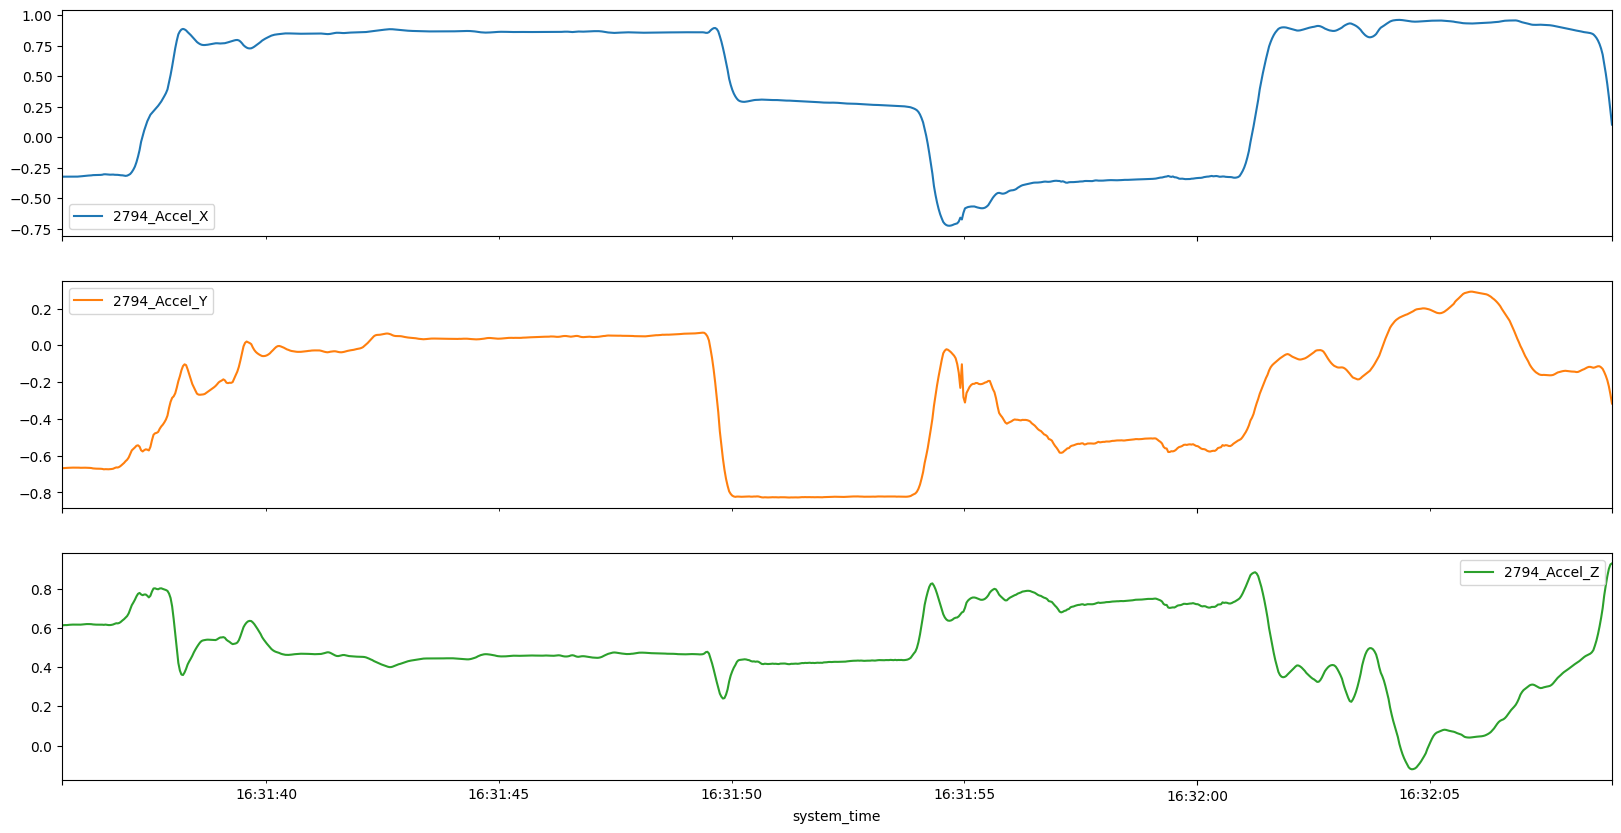

In [27]:
# No idea why this takes so long to plot with just 3 channels and 1K rows
# df[['2794_Accel_X','2794_Accel_Y','2794_Accel_Z']].iloc[999:1999].plot(subplots=True, figsize=(20, 10)) # yay Pandas

# Main is setup to be a demo and bit of unit test.

In [ ]:
verbose = False # otherwise a lot of output from main.

In [ ]:
if __name__ == "__main__":
    print("Get PSG-Audio (50 sub version)")
    x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                             = psg_audio_load_dataset(incl_val_group = True,
                                                      return_info_dict = True)
    headers = ("Array","shape", "data type")
    mydata = [("x_train:", x_train.shape, x_train.dtype),
            ("y_train:", y_train.shape, y_train.dtype),
            ("x_valid:", x_valid.shape, x_valid.dtype),
            ("y_valid:", y_valid.shape, y_valid.dtype),
            ("x_test:", x_test.shape, x_test.dtype),
            ("y_test:", y_test.shape, y_test.dtype)]
    print("\n",tabulate(mydata, headers=headers))
    print ('\n','-'*72) # just a dashed line

    print("\n----------- Contents of returned log_info ---------------")
    print(log_info)

Get PSG-Audio (50 sub version)
er1_sub_list [999, 1000, 1006, 1008, 1010, 1097, 1106, 1108, 1110, 1024, 1026, 1037, 1120, 1041, 1045, 1057, 1059, 1135, 1071, 1082, 1139, 1028, 1143, 1147, 1169, 1172, 1204, 1182, 1186, 1210, 1215, 1217, 1200, 1202, 1226, 1241, 1250, 1262, 1270, 1282, 1285, 1153, 1161, 1176, 1195, 1295, 1299, 1239, 1303, 1305, 1254, 1258, 1265, 1268, 1316, 1320, 1324, 1329, 1333, 1340, 1344, 1357, 1360, 1367, 1371, 1374, 1378, 1382, 1388, 1392, 1396, 1400, 1408, 1412, 1419, 1428, 1432, 1440, 1444, 1449, 1453, 1459, 1463, 1476, 1480, 1488]


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



 Array     shape              data type
--------  -----------------  -----------
x_train:  (243933, 500, 12)  float32
y_train:  (243933, 2)        uint8
x_valid:  (0, 500, 12)       float32
y_valid:  (0, 2)             uint8
x_test:   (0, 500, 12)       float32
y_test:   (0, 2)             uint8

 ------------------------------------------------------------------------

----------- Contents of returned log_info ---------------
Generated by PSG-Audio_load_dataset_10_90.ipynb
March 16, 2023
sub dict = {'train_subj': [999, 1000, 1006, 1008, 1010, 1097, 1106, 1108, 1110, 1024, 1026, 1037, 1120, 1041, 1045, 1057, 1059, 1135, 1071, 1082, 1139, 1028, 1143, 1147, 1169, 1172, 1204, 1182, 1186, 1210, 1215, 1217, 1200, 1202, 1226, 1241, 1250, 1262, 1270, 1282, 1285, 1153, 1161, 1176, 1195, 1295, 1299, 1239, 1303, 1305, 1254, 1258, 1265, 1268, 1316, 1320, 1324, 1329, 1333, 1340, 1344, 1357, 1360, 1367, 1371, 1374, 1378, 1382, 1388, 1392, 1396, 1400, 1408, 1412, 1419, 1428, 1432, 1440, 1444, 1449,

# Special processing due to highly unbalanced nature of PSG_Audio
This drops approximately 2/3rds of the normal samples from the training set and half the normal samples from the validation set.   Should probably look at the splits first and make a more algorithmic decision.

Note this version is setup for 20s window which is extremely unbalanced - the mod values will need to be changed for any other window size.

This really needs to be put into a function or use existing libraries.  Good write-up here:
https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704


In [ ]:
y_train_bin = np.argmax(y_train, axis=-1) # undo one-hot encoding
y_valid_bin = np.argmax(y_valid, axis=-1) # undo one-hot encoding
balancing_info = "Rebalancing by dropping some 'normal' windows, see notes.\n"
balancing_info += "Train counts before:\n"
unique, counts = np.unique(y_train_bin, return_counts=True)
balancing_info += str(np.asarray((unique, counts)).T) + "\n"
balancing_info += "Valid counts before:\n"
unique, counts = np.unique(y_valid_bin, return_counts=True)
balancing_info += str(np.asarray((unique, counts)).T) + "\n"
# This drops any 'normal' window that has a value not evenly
# divisible by 3.  Not exactly 2 in 3 but close for very unbalanced
idx = []
for i in range(y_train_bin.shape[0]):
    if (y_train_bin[i] == 0) and (i%3 == 0):  # set mod based on imbalance
        idx.append(True)
    elif (y_train_bin[i] == 1):
        idx.append(True)
    else:
        idx.append(False)
y_train = y_train[idx]
x_train = x_train[idx]
# repeat for valid set since accuracy metric used for hyper-tuning
idx = []
for i in range(y_valid_bin.shape[0]):
    if (y_valid_bin[i] == 0) and (i%6 == 0):
        idx.append(True)
    elif (y_valid_bin[i] == 1):
        idx.append(True)
    else:
        idx.append(False)
y_valid = y_valid[idx]
x_valid = x_valid[idx]
unique, counts = np.unique(np.argmax(y_train, axis=-1), return_counts=True)
balancing_info += "Train counts after:\n"
balancing_info += str(np.asarray((unique, counts)).T) +"\n"
unique, counts = np.unique(np.argmax(y_valid, axis=-1), return_counts=True)
balancing_info += "Valid counts after:\n"
balancing_info += str(np.asarray((unique, counts)).T) +"\n"
print(balancing_info)

headers = ("Array","shape", "data type")
mydata = [("x_train:", x_train.shape, x_train.dtype),
        ("y_train:", y_train.shape, y_train.dtype),
        ("x_valid:", x_valid.shape, x_valid.dtype),
        ("y_valid:", y_valid.shape, y_valid.dtype),
        ("x_test:", x_test.shape, x_test.dtype),
        ("y_test:", y_test.shape, y_test.dtype)]
print("\n",tabulate(mydata, headers=headers))

Rebalancing by dropping some 'normal' windows, see notes.
Train counts before:
[[     0 182208]
 [     1  61725]]
Valid counts before:
[]
Train counts after:
[[    0 60628]
 [    1 61725]]
Valid counts after:
[]


 Array     shape              data type
--------  -----------------  -----------
x_train:  (122353, 500, 12)  float32
y_train:  (122353, 2)        uint8
x_valid:  (0, 500, 12)       float32
y_valid:  (0, 2)             uint8
x_test:   (0, 500, 12)       float32
y_test:   (0, 2)             uint8


#Save arrays to drive
This is common code and untested - TWristAR is small so download and processing is fast.

For some of the larger datsets it is a big time benefit to store the arrays either before or after train/test split.  

In [ ]:
if True: #change to true to save files interactively
    output_dir = '/content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_12ch_unlabeled_86sub'
    if (os.path.isdir(output_dir)):
        #quick check for existing files, '.ipynb_checkpoints' file 
        #makes it more complicated to see if directory is empty
        if (not os.path.isfile(output_dir + '/x_train.npy')):
            summary = "PSG-Audio data 86 subs at 5s window and 5s step.\n"
            summary += "Saved to " + output_dir + "\n"
            summary += "Generated by PSG-Audio_load_dataset_10_90.ipynb"
            summary += " on " + time.strftime('%b-%d-%Y_%H%M', time.localtime())
            summary += "\nthis version for fusion of learned representation work\n"
            summary += "contains data 9 200Hz channels downsample to 100Hz and\n"
            summary += "All subs allocated to train.\n"
            summary += "3 100Hz channels and 20 strided subs that are allocated as\n"
            summary += "3 to train, 1 to valid, 1 to test, round-robin repeat.\n"
            summary += "IMPORTANT:  This is a work in progress version\n"
            summary += "Early attempts to convert to binary and balance have\n"
            summary += "been made and minimally tested.  In particular the\n"
            summary += "stats may not reflect the final changes made.\n"
            info_fname = output_dir +'/'+'README.txt'
            # xys_info not defined if run mostly interactive
            #full_info = summary + "\n" + xys_info + "\n" + log_info +'\n' + balancing_info +'\n'
            full_info = summary + "\n" + log_info +'\n' +'\n'
            print(full_info)

            with open(info_fname, "w") as file_object:
                file_object.write(full_info)
            if True:
                np.save(output_dir + '/'+'x_train.npy',x_train)
                np.save(output_dir + '/'+'y_train.npy',y_train)
                np.save(output_dir + '/'+'x_valid.npy',x_valid)
                np.save(output_dir + '/'+'y_valid.npy',y_valid)
                np.save(output_dir + '/'+'x_test.npy',x_test)
                np.save(output_dir + '/'+'y_test.npy',y_test)

        else:
            print("Error "+output_dir+" contains x_train.npy, please delete files")
    else:
        print(output_dir + " not found, please create directory") 

PSG-Audio data 86 subs at 5s window and 5s step.
Saved to /content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_12ch_unlabeled_86sub
Generated by PSG-Audio_load_dataset_10_90.ipynb on Dec-14-2022_2211
this version for fusion of learned representation work
contains data 9 200Hz channels downsample to 100Hz and
All subs allocated to train.
3 100Hz channels and 20 strided subs that are allocated as
3 to train, 1 to valid, 1 to test, round-robin repeat.
IMPORTANT:  This is a work in progress version
Early attempts to convert to binary and balance have
been made and minimally tested.  In particular the
stats may not reflect the final changes made.

Generated by PSG-Audio_load_dataset_10_90.ipynb
December 14, 2022
sub dict = {'train_subj': [999, 1000, 1006, 1008, 1010, 1097, 1106, 1108, 1110, 1024, 1026, 1037, 1120, 1041, 1045, 1057, 1059, 1135, 1071, 1082, 1139, 1028, 1143, 1147, 1169, 1172, 1204, 1182, 1186, 1210, 1215, 1217, 1200, 1202, 1226, 1241, 1250, 1262, 1270, 1282, 1285, 1153, 11

# The code gutter...

In [ ]:
# # Split all subjects with 10% going to "labeled" set and remander to "unlabeled"
# labeled_subs_list = all_sub_list[::10]
# # credit Donut https://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another
# # this removes the labeled subs from the full list to leave the unlabeled ones
# unlabeled_subs_list = [x for x in all_sub_list if x not in labeled_subs_list]
# print(labeled_subs_list)
# print(len(labeled_subs_list),"labeled subs")
# print(unlabeled_subs_list)
# print(len(unlabeled_subs_list),"unlabeled subs")

[995, 1095, 1112, 1126, 1137, 1155, 1206, 1198, 1249, 1151, 1228, 1252, 1274, 1335, 1365, 1384, 1406, 1436, 1457, 1492]
20 labeled subs
[999, 1086, 1000, 1088, 1006, 1089, 1008, 1093, 1010, 1014, 1097, 1016, 1106, 1018, 1108, 1020, 1110, 1022, 1024, 1116, 1026, 1118, 1037, 1039, 1120, 1122, 1041, 1043, 1045, 1127, 1057, 1129, 1059, 1131, 1135, 1069, 1071, 1073, 1082, 1084, 1139, 1145, 1028, 1104, 1143, 1157, 1147, 1163, 1169, 1171, 1172, 1174, 1204, 1178, 1182, 1208, 1186, 1191, 1210, 1193, 1215, 1197, 1217, 1219, 1200, 1222, 1202, 1224, 1226, 1232, 1241, 1247, 1250, 1256, 1262, 1263, 1270, 1276, 1282, 1284, 1285, 1287, 1153, 1288, 1161, 1290, 1176, 1292, 1195, 1294, 1295, 1230, 1299, 1234, 1239, 1301, 1303, 1245, 1305, 1306, 1254, 1308, 1258, 1310, 1265, 1312, 1268, 1314, 1316, 1318, 1320, 1322, 1324, 1327, 1329, 1331, 1333, 1337, 1340, 1342, 1344, 1355, 1357, 1358, 1360, 1361, 1367, 1369, 1371, 1373, 1374, 1376, 1378, 1380, 1382, 1386, 1388, 1390, 1392, 1394, 1396, 1398, 1400, 1402, 

In [ ]:
def limit_channel_ir3(ir3_X, 
                      all_channel_list = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl', 'bvp', 'eda', 'p_temp'],
                      keep_channel_list = ["accel_ttl"]):
    """Pass the full ir3_X array with all channels, the stored all_channel_list
    that was extracted from the ir1 dataframe column names, and a 
    keep_channel_list.  Matching channels will be kept, all others dropped.
    This would have been much easier at IR1 but that would precluded channel 
    experiments and by channel feature representations.
    This is really new code, I'm leaving in some commented statements for now"""
    ch_idx = []
    # should add check here for channels not in list
    for i in keep_channel_list:
        ch_idx.append(all_channel_list.index(i)) 
    if verbose:
        print("Keeping X columns at index", ch_idx)
    new_X = ir3_X[:,:,ch_idx]
    return new_X
if interactive:
    print("all_channel_list", all_channel_list)
    print("starting X shape", my_X.shape)
    print("first row", my_X[0,0,:])
    my_new_X = limit_channel_ir3(my_X,
                                 keep_channel_list = ['accel_ttl','p_temp'])
    print("ending X shape", my_new_X.shape)
    print("first row", my_new_X[0,0,:])

In [ ]:
def drop_label_ir2_ir3(X, y, sub, label_to_drop):
    """removes windows with label = label_to_drop from either IR2 or IR3
    Returns updated version of IRX - X, y, sub"""
    # Also copied directly from SHL - double Yay!
    idx = []
    for i in range(y.shape[0]):
        if (y[i] == label_to_drop):
            idx.append(False)
        else:
            idx.append(True)
            #print('Discarding Row:', i)
    X = X[idx]
    y = y[idx]
    sub = sub[idx]
    return X, y, sub
if interactive:
    print("Label counts before drop")
    unique, counts = np.unique(my_y, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print('X, y, sub array shapes before label drop', my_X.shape, my_y.shape, my_sub.shape)
    my_X, my_y, my_sub = drop_label_ir2_ir3(my_X, my_y, my_sub, 'Undefined')
    print("Label counts after drop")
    unique, counts = np.unique(my_y, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print('IR2 shapes after label drop', my_X.shape, my_y.shape, my_sub.shape)
    headers = ("array","shape", "object type", "data type")
    mydata = [("my_X:", my_X.shape, type(my_X), my_X.dtype),
            ("my_y:", my_y.shape ,type(my_y), my_y.dtype),
            ("my_sub:", my_sub.shape, type(my_sub), my_sub.dtype)]
    print("IR2 array info after label drop")
    print(tabulate(mydata, headers=headers))

Label counts before drop
[[   0 2637]
 [   1  453]
 [   2   39]]
X, y, sub array shapes before label drop (3129, 500, 9) (3129, 1) (3129, 1)
Label counts after drop
[[   0 2637]
 [   1  453]
 [   2   39]]
IR2 shapes after label drop (3129, 500, 9) (3129, 1) (3129, 1)
IR2 array info after label drop
array    shape           object type              data type
-------  --------------  -----------------------  -----------
my_X:    (3129, 500, 9)  <class 'numpy.ndarray'>  float32
my_y:    (3129, 1)       <class 'numpy.ndarray'>  int8
my_sub:  (3129, 1)       <class 'numpy.ndarray'>  int8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [ ]:
if interactive:
    import matplotlib.pyplot as plt # for plotting

In [ ]:
# Plot y - must convert to numeric first
def plot_activities():
    uniques, y_num = np.unique(y, return_inverse=True)
    print (uniques)
    plt.plot(y_num) 
    plt.show()
if (interactive):
    plot_activities()

In [ ]:
def plot_subjects():
    uniques, s_num = np.unique(sub, return_inverse=True)
    print (uniques)
    plt.plot(s_num) 
    plt.show()
if (interactive):
    plot_subjects()